<a href="https://colab.research.google.com/github/abar-1/SDR-ML-Project/blob/main/QAMReceiverv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Function to convert binary data to QAM16 constellations

In [7]:
pip install tensorflow

16QAM Constellation Modulator

In [34]:
from numpy import log2, arange, sqrt, flip, concatenate, zeros, array, floor, sqrt, array, bitwise_xor

#Converts binary data to complex
#Serves as the 16QAM constellation modulator
def modulator(data, M, code='gray', data_type='binary'):
	# Constants
	sqrt_M = sqrt(M).astype(int)
	k = log2(M).astype(int)

	# Binary to Gray code constelation convertor
	vect = array(range(sqrt_M))
	gray_constallation = bitwise_xor(vect, floor(vect/2).astype(int))

	# Gray code constelation to symbols convertor
	vect = arange(1, sqrt(M), 2)
	symbols = concatenate((flip(-vect, axis=0), vect)).astype(int)

	# Modulation
	if data_type == 'binary':
		# Data handling
		data_input = data.reshape((-1,k))
		I = zeros((data_input.shape[0],))
		Q = zeros((data_input.shape[0],))
		for n in range(int(data_input.shape[1] / 2)):
			I = I + data_input[:,n] * 2 ** n
		for n in range(int(data_input.shape[1]/2),int(data_input.shape[1])):
			Q = Q + data_input[:,n] * 2 ** (n - int(data_input.shape[1]/2))
	elif data_type == 'numbers':
		tmp = data / sqrt_M
		Q = floor(tmp)
		I = (tmp - Q) * 4
	else:
		return 0

	I = I.astype(int)
	Q = Q.astype(int)

	if code == 'gray':
		I = gray_constallation[I]
		Q = gray_constallation[Q]

	I = symbols[I]
	Q = symbols[Q]

	S = I + 1j * Q

	return S

print(modulator(array([1, 0, 1, 1]), 16))

[-1.+1.j]


Getting Binary and Complex Data into df

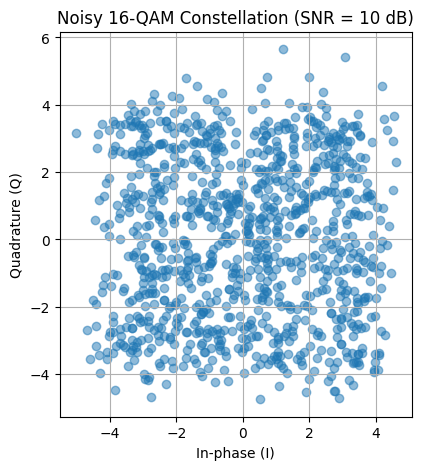

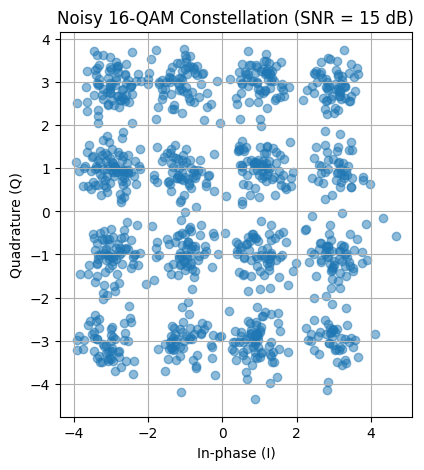

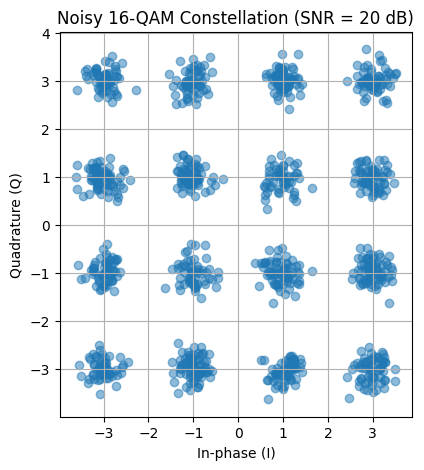

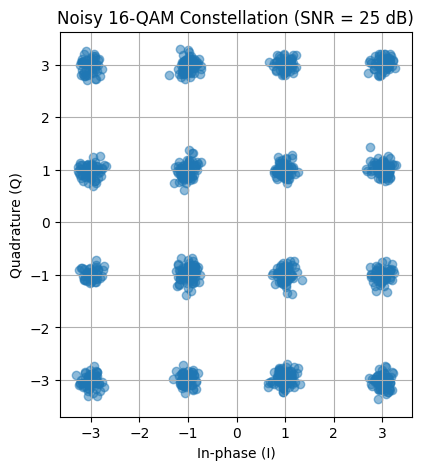

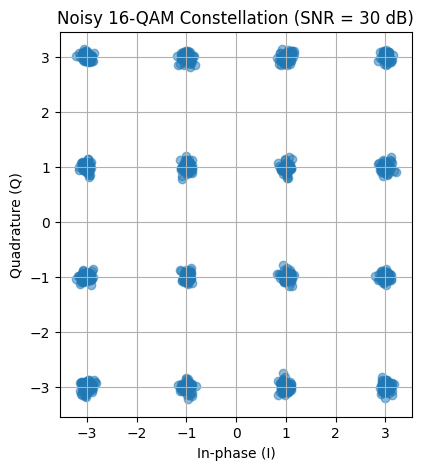

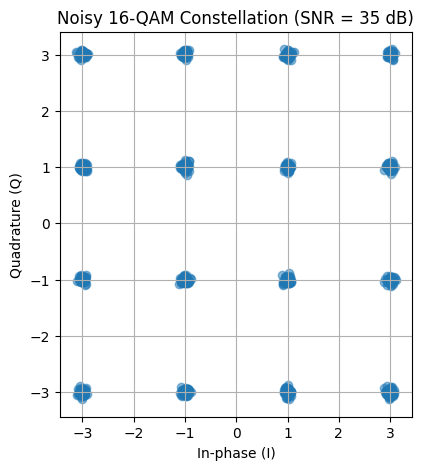

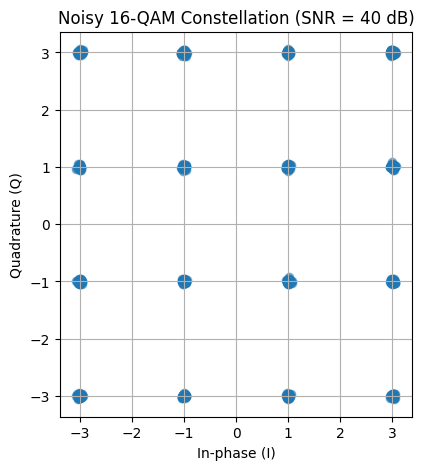

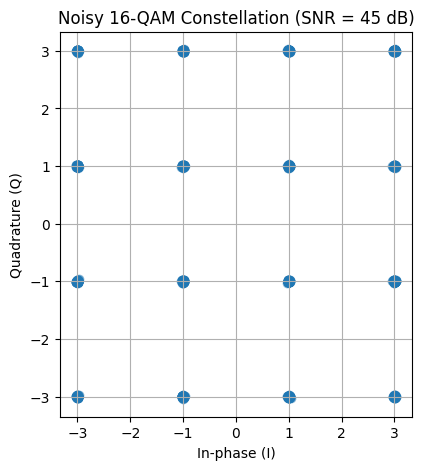

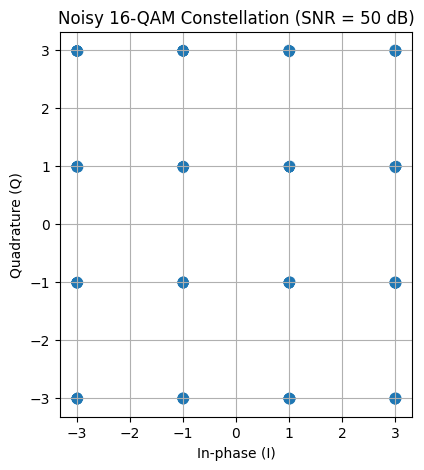

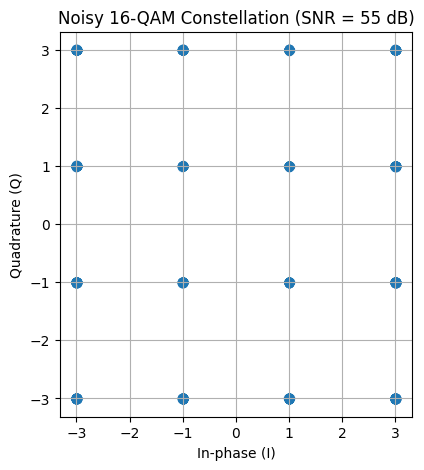

,binary,complex
0,"[1, 1, 1, 0]",0.422638-1.929014j
1,"[0, 1, 0, 0]",3.031281-2.483848j
2,"[1, 0, 1, 1]",-0.980116+1.232092j
3,"[0, 1, 0, 1]",2.296622+2.748076j
4,"[0, 1, 1, 0]",2.294070-1.384449j
...,...,...
995,"[0, 1, 1, 0]",3.002008-0.997553j
996,"[1, 0, 0, 0]",-1.002954-3.000412j
997,"[0, 1, 1, 0]",3.000010-0.998260j
998,"[0, 1, 1, 1]",3.001456+1.007281j


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_qam_symbols(M=16, num_symbols=1000):
    #4 bits per symbol
    k = int(np.log2(M))
    #Generate random binary data
    random_bits = np.random.randint(0, 2, num_symbols * k)
    #Reshape to match modulater input
    binary_data = random_bits.reshape((-1, k))
    #Modulate Binary Data
    modulated_symbols = modulator(binary_data, M)
    return modulated_symbols, binary_data

def add_awgn(qam_symbols, snr_db):
    """
    Adds Additive White Gaussian Noise (AWGN) to QAM symbols.

    Parameters:
        qam_symbols (numpy array): The transmitted QAM symbols (complex numbers).
        snr_db (float): Signal-to-noise ratio in dB.

    Returns:
        numpy array: Noisy QAM symbols.
    """
    # Calculate signal power
    signal_power = np.mean(np.abs(qam_symbols) ** 2)

    # Compute noise power based on SNR (convert dB to linear scale)
    noise_power = signal_power / (10 ** (snr_db / 10))

    # Generate AWGN noise
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*qam_symbols.shape) + 1j * np.random.randn(*qam_symbols.shape))

    # Add noise to the symbols
    noisy_qam_symbols = qam_symbols + noise
    return noisy_qam_symbols


# Generate 16QAM symbols
M = 16
num_symbols = 1000
qam_symbols, original_binary = generate_qam_symbols(M, num_symbols)

#Signal to noise ratio in dB
snr_db = 15


# Add noise to QAM symbols
noisy_qam = add_awgn(qam_symbols, snr_db)

df = pd.DataFrame({'features':original_binary.tolist(), 'target':noisy_qam.tolist()})
df.reset_index(inplace=True)

df.drop(['index'],axis=1,inplace=True)

#Getting data of different noise levels (data augmentation to prevent overfitting)
for i in range(10, 60, 5):
  M = 16
  num_symbols = 1000
  qam_symbols, original_binary = generate_qam_symbols(M, num_symbols)
  snr_db = i
  noisy_qam = add_awgn(qam_symbols, snr_db)
  df1 = pd.DataFrame({'features':original_binary.tolist(), 'target':noisy_qam.tolist()})
  df1.reset_index(inplace=True)
  df1.drop(['index'],axis=1,inplace=True)
  df = pd.concat([df, df1])

  #Plot Constellations (Before and After Noise)
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,2)
  plt.scatter(noisy_qam.real, noisy_qam.imag, alpha=0.5, label="Noisy")
  plt.title(f"Noisy {M}-QAM Constellation (SNR = {snr_db} dB)")
  plt.xlabel("In-phase (I)")
  plt.ylabel("Quadrature (Q)")
  plt.grid()

  plt.show()

df = df.rename(columns={'features': 'binary','target':'complex'})

df


Build Neural Network

X = Complex

y = Binary

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

#Target variable (binary data)
y = df['binary'].values
# Convert each element of y to a NumPy array
y = np.array([np.array(yi) for yi in y])
#Reshape to 4 bits/symbol (-1 means numpy will figure out how many rows are needed)
y = y.reshape(-1, 4)
y = y.astype(int)

# Manually convert 4-bit binary to integer (0-15)
y = np.array([int("".join(str(bit) for bit in row), 2) for row in y])

# One-hot encoding for 16 classes
y = to_categorical(y, num_classes=16)


# Features (complex data)
X = df['complex'].values
X = np.array([np.array(xi) for xi in X])

# Reshape to (n_samples, 2) for real and imaginary parts
X = [[x.real, x.imag] for x in X]
X = np.array(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train[:5])
print(y_train[:5])

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # 16 neurons for 16 different possibilities (0000 - 1111)
    Dense(16, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



[[0.4226 -1.9290]
 [3.0313 -2.4838]
 [-0.9801 1.2321]
 [2.2966 2.7481]
 [2.2941 -1.3844]]
[[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 1.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 1.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]]
[[-3.0021 -2.9944]
 [3.0175 0.9695]
 [-2.9999 -3.0347]
 [0.9273 2.9910]
 [1.0220 1.0055]]
[[1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000
  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3143 - loss: 2.2388 - val_accuracy: 0.9062 - val_loss: 0.9149
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7806 - loss: 0.7836 - val_accuracy: 0.9727 - val_loss: 0.2799
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8711 - loss: 0.5021 - val_accuracy: 0.9744 - val_loss: 0.1390
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9124 - loss: 0.3519 - val_accuracy: 0.9756 - val_loss: 0.1080
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9339 - loss: 0.2788 - val_accuracy: 0.9739 - val_loss: 0.0986
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9380 - loss: 0.2379 - val_accuracy: 0.9756 - val_loss: 0.0919
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9441 - loss: 0.2164 - val_accuracy: 0.9739 - val_loss: 0.0928
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9461 - loss: 0.2193 - val_accuracy: 0.

Make NN with last layer w/ 1 neuron

Use same training data

Save Train and Test as CSV



Stage 1: Put the last layer as linear activation, map to 0-15

Stage 2: See if we can use decision trees (what accuracy? how does it compare?)

Stage 3: Increase size of dataset to 20k

In [36]:
X_pred = np.array([[3, -3],[1, -3],[3, -1],[-1, 3]])  # Convert X_pred to a NumPy array

predictions = model.predict(X_pred)
print(f"Predicted: {predictions[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted: [0.0000 0.0000 0.0000 0.0000 0.9996 0.0000 0.0001 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0003 0.0000 0.0000 0.0000]
